In [10]:
# mount drive + set paths + load sets + list graphs

from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import pandas as pd
import numpy as np

BASE = Path("/content/drive/MyDrive/biolip_gnn")

SUBSET_PATH = BASE / "out" / "subset_200.csv"
GRAPHS_DIR  = BASE / "graphs"

# new output folder to keep things clean
LABELED_DIR = BASE / "graphs_labeled_v3"
LABELED_DIR.mkdir(exist_ok=True)

df = pd.read_csv(SUBSET_PATH)

graph_files = sorted(GRAPHS_DIR.glob("*.npz"))
print("subset rows:", len(df))
print("graphs found:", len(graph_files))
print("output folder:", LABELED_DIR)
print("example graph:", graph_files[0].name if graph_files else "NONE")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
subset rows: 200
graphs found: 50
output folder: /content/drive/MyDrive/biolip_gnn/graphs_labeled_v3
example graph: 1KMM_C.npz


In [11]:
# build a lookup

df["pdb_id"] = df["pdb_id"].astype(str).str.strip().str.upper()
df["chain"] = df["chain"].astype(str).str.strip()

row_lookup = {f"{r.pdb_id}_{r.chain}": r for _, r in df.iterrows()}

print("lookup entries:", len(row_lookup))
print("sample keys:", list(row_lookup.keys())[:5])

lookup entries: 200
sample keys: ['9HIJ_A', '7M3Y_B', '1W58_1', '4PDD_A', '1M3U_A']


In [12]:
# extract binding residue numbers from raw_line and force pdb_resse labeling

import re

RES_TOKEN = re.compile(r"^[A-Z]\d+$")

def binding_nums_from_rawline(raw_line: str) -> set:
    """
    Pull residue-number tokens like E83, R259 from the raw BioLiP line.
    Returns a set of integers (83, 259, ...).
    """
    if not isinstance(raw_line, str) or not raw_line.strip():
        return set()
    tokens = raw_line.replace("\t", " ").split()
    res_tokens = [t for t in tokens if RES_TOKEN.match(t)]
    return set(int(t[1:]) for t in res_tokens)

def make_y_for_graph(binding_nums: set, resseq: np.ndarray) -> np.ndarray:
    """
    Force PDB residue-number alignment:
    y[i]=1 if resseq[i] in binding_nums else 0
    """
    y = np.zeros(len(resseq), dtype=np.int64)
    if not binding_nums:
        return y
    bset = set(int(x) for x in binding_nums)
    for i, rnum in enumerate(resseq.tolist()):
        if int(rnum) in bset:
            y[i] = 1
    return y



In [13]:
# label 50 graphs, save labeled .npz, and write stats
import json

TARGET = min(50, len(graph_files))
to_label = graph_files[:TARGET]

stats = []
fails = []

for gf in to_label:
    key = gf.stem  # e.g., "1KMM_C"
    r = row_lookup.get(key, None)

    if r is None:
        fails.append({"graph": key, "error": "No matching row in subset_200.csv"})
        continue

    raw_line = r.get("raw_line", "")

    try:
        g = np.load(gf, allow_pickle=True)

        resseq = g["resseq"]
        n_nodes = int(g["n_nodes"])
        n_edges = int(g["n_edges"])

        binding_nums = binding_nums_from_rawline(raw_line)
        y = make_y_for_graph(binding_nums, resseq)

        pos = int(y.sum())
        pos_rate = float(pos / n_nodes) if n_nodes else 0.0

        out_path = LABELED_DIR / gf.name
        np.savez_compressed(
            out_path,
            pdb_id=g["pdb_id"],
            chain=g["chain"],
            coords=g["coords"],
            x_idx=g["x_idx"],
            edge_index=g["edge_index"],
            edge_dist=g["edge_dist"],
            resseq=g["resseq"],
            n_nodes=g["n_nodes"],
            n_edges=g["n_edges"],
            y=y,
            label_mode=np.array("pdb_resseq_forced"),
        )

        stats.append({
            "graph": key,
            "status": "OK",
            "n_nodes": n_nodes,
            "n_edges": n_edges,
            "binding_nums_count": len(binding_nums),
            "positives": pos,
            "positive_rate": pos_rate,
            "label_mode": "pdb_resseq_forced"
        })

    except Exception as e:
        fails.append({"graph": key, "error": str(e)})

stats_df = pd.DataFrame(stats)
fails_df = pd.DataFrame(fails)

print("Labeled OK:", len(stats_df), "/", TARGET)
print("Failures:", len(fails_df))

STATS_PATH = LABELED_DIR / "day5_label_stats.csv"
FAILS_PATH = LABELED_DIR / "day5_failures.json"

stats_df.to_csv(STATS_PATH, index=False)
FAILS_PATH.write_text(json.dumps(fails, indent=2), encoding="utf-8")

print("Saved stats:", STATS_PATH)
print("Saved failures:", FAILS_PATH)


Labeled OK: 50 / 50
Failures: 0
Saved stats: /content/drive/MyDrive/biolip_gnn/graphs_labeled_v3/day5_label_stats.csv
Saved failures: /content/drive/MyDrive/biolip_gnn/graphs_labeled_v3/day5_failures.json


       positives  positive_rate  binding_nums_count
count   50.00000      50.000000           50.000000
mean    13.16000       0.065231           14.180000
std     10.09619       0.072211           10.691767
min      2.00000       0.008696            3.000000
25%      4.00000       0.020437            6.000000
50%     11.00000       0.054477           10.000000
75%     19.50000       0.076831           21.500000
max     48.00000       0.412500           48.000000


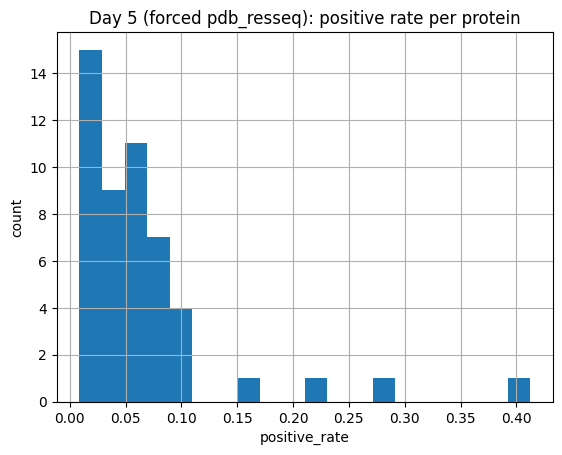


Example: 1KMM_C
n_nodes: 387
First 15 resseq: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Positives: 30
Label mode: pdb_resseq_forced


In [14]:
# inspect lavel quality (stats + histogram) and 1 sanity check
import matplotlib.pyplot as plt

print(stats_df[["positives", "positive_rate", "binding_nums_count"]].describe())

plt.figure()
stats_df["positive_rate"].astype(float).hist(bins=20)
plt.title("Day 5 (forced pdb_resseq): positive rate per protein")
plt.xlabel("positive_rate")
plt.ylabel("count")
plt.show()

#sanity check one labeled graph
example = stats_df.iloc[0]["graph"]
g = np.load(LABELED_DIR / f"{example}.npz", allow_pickle = True)
print("\nExample:", example)
print("n_nodes:", int(g["n_nodes"]))
print("First 15 resseq:", g["resseq"][:15].tolist())
print("Positives:", int(g["y"].sum()))
print("Label mode:", str(g["label_mode"]))
